# Data Review and Preprocessing

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data import create_record
import ztf # shared scritp where the util functions are stored

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Defining taxonomy

In [30]:
transient  = ['SNIa', 'nonSNIa']#['SNIa', 'SNIbc', 'SNII', 'SNIIn', 'SNIIb', 'SLSN', 'TDE']
stochastic = ['QSO', 'AGN', 'Blazar', 'CVNova', 'YSO']
periodic   = ['LPV', 'RSCVn', 'Ceph', 'EA', 'EBEW', 'RRLc', 'RRLab', 'DSCT', 'Periodic-Other']

In [31]:
class_code = transient+stochastic+periodic

### Getting lightcurves 

In [32]:
path_meta = './data/raw_data/ztf_forced/metadata.csv'
path_dete = './data/raw_data/ztf_forced/detections.csv'

In [33]:
%%time
detections = pd.read_csv(path_dete)
metadata   = pd.read_csv(path_meta)

CPU times: user 8.33 s, sys: 520 ms, total: 8.85 s
Wall time: 8.85 s


In [34]:
detections['fid'].value_counts()

2    6455579
1    4826663
3     236197
Name: fid, dtype: int64

In [35]:
detections = detections[detections['fid'] == 1] # single filter only
detections = detections[['oid', 'mjd', 'forcediffimflux', 'forcediffimfluxunc', 'forcediffimsnr']]

### Train val test 5-fold split

In [36]:
name = 'forced'
for fold_n in range(5):
    dataset_name = '{}_{}'.format(name, fold_n)
    print('[INFO] Processing {}'.format(dataset_name))
    train_df = metadata[metadata['partition'] == 'training_{}'.format(fold_n)]
    val_df   = metadata[metadata['partition'] == 'validation_{}'.format(fold_n)]
    test_df  = metadata[metadata['partition'] == 'test']
    
    result = pd.merge(detections,
                  test_df[['oid', 'alerceclass', 'partition']],
                  on='oid')
    
    x_train, y_train, id_train = ztf.get_light_curves(train_df, detections, class_code, n_min=10)
    x_val, y_val, id_val = ztf.get_light_curves(val_df, detections, class_code, n_min=10)
    x_test, y_test, id_test = ztf.get_light_curves(test_df, detections, class_code, n_min=0)\
    
    subsets = {'train':dict(), 'validation':dict(), 'test':dict()}
    subsets['train']['x'] = x_train
    subsets['train']['y'] = y_train
    subsets['train']['oid'] = id_train

    subsets['validation']['x'] = x_val
    subsets['validation']['y'] = y_val
    subsets['validation']['oid'] = id_val

    subsets['test']['x'] = x_test
    subsets['test']['y'] = y_test
    subsets['test']['oid'] = id_test
    
    X_train, y_train, m_train, o_train = ztf.pad_lightcurves(subsets['train']['x'], 
                                                             subsets['train']['y'], 
                                                             subsets['train']['oid'],
                                                             maxobs=200)
    X_valid, y_valid, m_valid, o_valid = ztf.pad_lightcurves(subsets['validation']['x'], 
                                                             subsets['validation']['y'], 
                                                             subsets['validation']['oid'],
                                                             maxobs=200)
    maxobs_testing = np.max([x.shape[0] for x in subsets['test']['x']])
    X_test, y_test, m_test, o_test = ztf.pad_lightcurves(subsets['test']['x'], 
                                                 subsets['test']['y'],
                                                 subsets['test']['oid'],
                                                 maxobs=maxobs_testing)

    create_record(light_curves=X_train, 
              labels=y_train, 
              masks=m_train, 
              oids=o_train, 
              path='./data/records/{}/train'.format(dataset_name))
    create_record(light_curves=X_valid, 
                  labels=y_valid, 
                  masks=m_valid, 
                  oids=o_valid, 
                  path='./data/records/{}/val'.format(dataset_name))
    create_record(light_curves=X_test, 
                  labels=y_test, 
                  masks=m_test, 
                  oids=o_test, 
                  path='./data/records/{}/test'.format(dataset_name))

    print('TRAIN: {}  - {}\nVALID: {}  - {}\nTEST:  {} - {}'.format(X_train.shape, y_train.shape,
                                                              X_valid.shape, y_valid.shape,
                                                              X_test.shape, y_test.shape))

[INFO] Processing forced_0


/home/cridonoso/Documents/2PhaseOrNot2Phase/ztf.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(light_curves), np.array(labels), np.array(oids)


TRAIN: (26862, 200, 4)  - (26862,)
VALID: (2916, 200, 4)  - (2916,)
TEST:  (1593, 992, 4) - (1593,)
[INFO] Processing forced_1
TRAIN: (26901, 200, 4)  - (26901,)
VALID: (2877, 200, 4)  - (2877,)
TEST:  (1593, 992, 4) - (1593,)
[INFO] Processing forced_2
TRAIN: (26857, 200, 4)  - (26857,)
VALID: (2921, 200, 4)  - (2921,)
TEST:  (1593, 992, 4) - (1593,)
[INFO] Processing forced_3
TRAIN: (26814, 200, 4)  - (26814,)
VALID: (2964, 200, 4)  - (2964,)
TEST:  (1593, 992, 4) - (1593,)
[INFO] Processing forced_4
TRAIN: (26773, 200, 4)  - (26773,)
VALID: (3005, 200, 4)  - (3005,)
TEST:  (1593, 992, 4) - (1593,)


In [26]:
# fig, axes = plt.subplots(1, 3, dpi=200, figsize=(10,5),sharey=True, 
#                         gridspec_kw={'hspace': 0., 'wspace': 0.05},)

# for i, (labs, name) in enumerate(zip([y_train, y_valid, y_test], ['train', 'val', 'test'])):
    
#     uniques, counts = np.unique(labs, return_counts=True)

#     LABELS = [class_code[u] for u in uniques]

#     axes[i].barh(uniques, counts, align='center', color='darkblue')

#     for u, c in zip(uniques, counts):
#         axes[i].text(c+1000, u-0.2, '{}'.format(c), fontsize=12)
    
#     x_ticks = range(len(uniques))
#     axes[i].set_yticks(x_ticks)
#     axes[i].set_yticklabels(LABELS)

#     axes[i].set_title('{}set distribution'.format(name), fontsize=15)
#     axes[i].set_xticks([])
#     axes[i].set_xlim(0, 30000)
    
# plt.show()

# Reading records

In [37]:
from data import load_record
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
dataset = load_record('./data/records/forced_0/train', batch_size=32, take=1)

[INFO] Taking 1 balanced batches


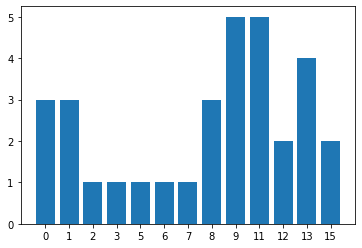

In [39]:
for x, y, m in dataset:    
    y_int = np.argmax(y, 1)
    unique, counts = np.unique(y_int, return_counts=True)
    x_range = range(len(unique))
    plt.bar(x_range, counts)
    plt.xticks(x_range, unique)
    break